In [10]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!wget https://transfer.sh/get/v6xRpgAaQE/FER2013.zip
!ls

--2023-12-08 08:46:56--  https://transfer.sh/get/v6xRpgAaQE/FER2013.zip
Resolving transfer.sh (transfer.sh)... 144.76.136.153, 2a01:4f8:200:1097::2
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63252113 (60M) [application/zip]
Saving to: ‘FER2013.zip’

FER2013.zip         100%[===================>]  60.32M  17.7MB/s    in 4.0s    

2023-12-08 08:47:00 (14.9 MB/s) - ‘FER2013.zip’ saved [63252113/63252113]

FER2013.zip


In [3]:
!unzip FER2013.zip 1> /dev/null

In [4]:
!mv train/angry train/0
!mv train/disgust train/1
!mv train/fear train/2
!mv train/happy train/3
!mv train/neutral train/4
!mv train/sad train/5
!mv train/surprise train/6

In [5]:
img_array = cv2.imread("/kaggle/working/train/0/Training_87452062.jpg")

In [6]:
img_array.shape

(48, 48, 3)

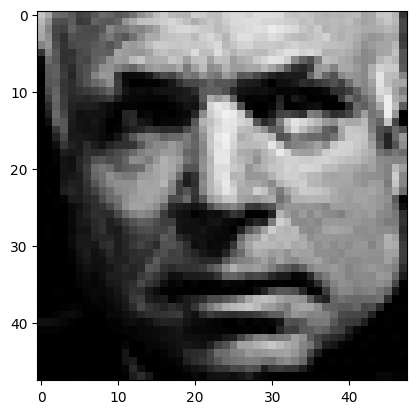

In [7]:
plt.imshow(img_array)

In [8]:
Datadirectory = "/kaggle/working/train/"

In [9]:
Classes = ["0", "1", "2", "3", "4", "5", "6"]

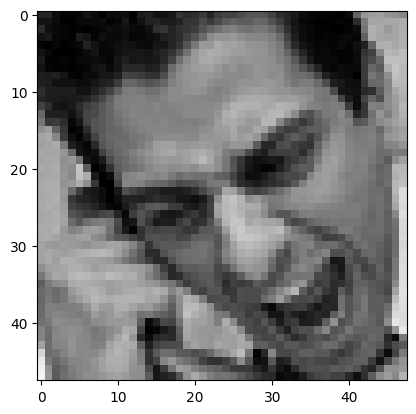

In [10]:
for category in Classes:
  path = os.path.join(Datadirectory, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img))
    plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
    plt.show()
    break # break or else it will display all the images
  break #same as above

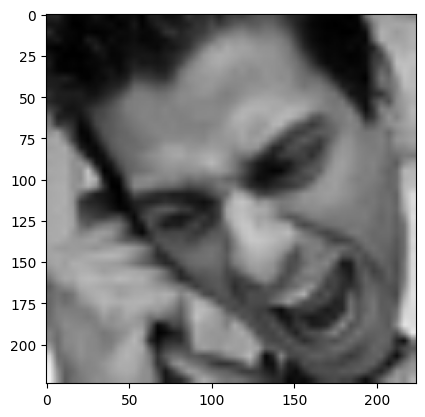

In [11]:
img_size = 224 #ImageNet
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
new_array.shape #converted size to standard to use transfer learning

(224, 224, 3)

In [13]:
# read all the images and convert them to array
training_Data = []
def create_training_Data():
  for category in Classes:
    path = os.path.join(Datadirectory, category)
    class_num = Classes.index(category) # 0, 1, ... labels
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (img_size, img_size))
        training_Data.append([new_array, class_num])
      except Exception as e:
        pass

In [14]:
create_training_Data()

In [15]:
print(len(training_Data))

28709


In [16]:
import random
random.shuffle(training_Data)

In [17]:
type(training_Data)

list

In [18]:
training_Data = training_Data[:len(training_Data)//5]

In [19]:
print(len(training_Data))

5741


In [20]:
X = []
y = []

for features, label in training_Data:
  X.append(features)
  y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 3)

In [21]:
X.shape

(5741, 224, 224, 3)

In [22]:
# import numpy as np

# # Assuming X is a NumPy array
# X_shape = X.shape
# batch_size = 1000  # Adjust the batch size based on your available memory

# for i in range(0, X_shape[0], batch_size):
#     start_idx = i
#     end_idx = min(i + batch_size, X_shape[0])

#     # Normalize the current batch
#     X[start_idx:end_idx] = X[start_idx:end_idx] / 255.0

# This will normalize the entire array in batches
#---------------Previous--------------
X = X/255.0;

In [23]:
Y = np.array(y)

In [11]:
## deep learning model - transfer learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [25]:
model = tf.keras.applications.MobileNetV2() # pretrained model

14536120/14536120 [==============================] - 0s 0us/step


In [26]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [27]:
base_input = model.layers[0].input

In [28]:
base_output = model.layers[-2].output

In [29]:
base_output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [30]:
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output)

In [31]:
final_output

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_2')>

In [32]:
new_model = keras.Model(inputs=base_input, outputs=final_output)

In [33]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [34]:
new_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [35]:
new_model.fit(X, Y, epochs=25)

Epoch 1/25
180/180 [==============================] - 53s 89ms/step - loss: 1.4517 - accuracy: 0.4478
Epoch 2/25
180/180 [==============================] - 15s 85ms/step - loss: 1.2110 - accuracy: 0.5417
Epoch 3/25
180/180 [==============================] - 15s 85ms/step - loss: 1.1108 - accuracy: 0.5816
Epoch 4/25
180/180 [==============================] - 15s 85ms/step - loss: 1.0490 - accuracy: 0.6063
Epoch 5/25
180/180 [==============================] - 15s 85ms/step - loss: 0.9620 - accuracy: 0.6339
Epoch 6/25
180/180 [==============================] - 15s 85ms/step - loss: 0.8805 - accuracy: 0.6631
Epoch 7/25
180/180 [==============================] - 15s 85ms/step - loss: 0.7986 - accuracy: 0.6929
Epoch 8/25
180/180 [==============================] - 15s 85ms/step - loss: 0.7396 - accuracy: 0.7253
Epoch 9/25
180/180 [==============================] - 15s 85ms/step - loss: 0.6687 - accuracy: 0.7558
Epoch 10/25
180/180 [==============================] - 15s 85ms/step - loss: 0.608

In [36]:
new_model.save('InnerView_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
model.save('my_model.keras')

In [4]:
new_model = tf.keras.models.load_model('/home/byte/Projects/github/InnerView/InnerView_model.h5')

2023-12-08 19:09:44.980626: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [39]:
new_model.evaluate

<bound method Model.evaluate of <keras.src.engine.functional.Functional object at 0x7af04c436b90>>

In [58]:
!wget "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/Katy_Perry_UNICEF_2012.jpg/655px-Katy_Perry_UNICEF_2012.jpg"

--2023-12-08 09:25:39--  https://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/Katy_Perry_UNICEF_2012.jpg/655px-Katy_Perry_UNICEF_2012.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120308 (117K) [image/jpeg]
Saving to: ‘655px-Katy_Perry_UNICEF_2012.jpg’

655px-Katy_Perry_UN 100%[===================>] 117.49K  --.-KB/s    in 0.03s   

2023-12-08 09:25:39 (3.61 MB/s) - ‘655px-Katy_Perry_UNICEF_2012.jpg’ saved [120308/120308]



In [5]:
frame = cv2.imread("/home/byte/Projects/github/InnerView/655px-Katy_Perry_UNICEF_2012.jpg")

In [6]:
frame.shape

(768, 655, 3)

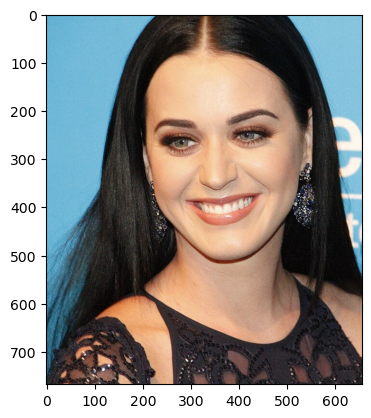

In [7]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [45]:
# face detection algorithm
!wget "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"

--2023-12-08 09:08:25--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.07s   

2023-12-08 09:08:26 (13.6 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [13]:
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [14]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [15]:
gray.shape

(768, 655)

In [19]:
faces = faceCascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) == 0:
        print("Face not detected")
    else:
        for (ex, ey, ew, eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex:ex+ew]

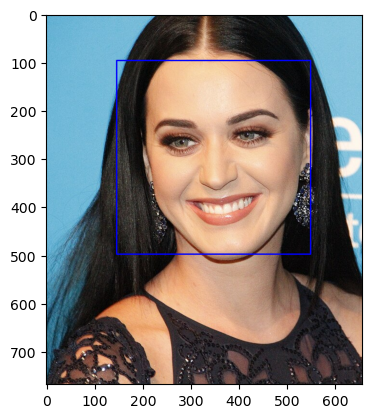

In [20]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

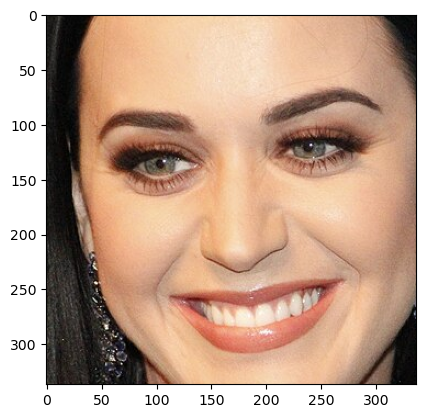

In [21]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [22]:
final_image = cv2.resize(face_roi, (224, 224))
final_image = np.expand_dims(final_image, axis=0)
final_image = final_image/255.0

In [23]:
Predictions = new_model.predict(final_image)

1/1 [==============================] - 1s 640ms/step


In [24]:
Predictions[0]

array([1.7506445e-05, 5.6260139e-09, 5.5056866e-02, 8.9670229e-01,
       1.1870268e-04, 2.6977317e-05, 4.8077650e-02], dtype=float32)

In [25]:
def emotion(value):
    if (value==0):
        return "angry"
    elif (value==1):
        return "disgust"
    elif (value==2):
        return "fear"
    elif (value==3):
        return "happy"
    elif (value==4):
        return "neutral"
    elif (value==5):
        return "sad"
    elif (value==6):
        return "surprise"

In [26]:
print(emotion(np.argmax(Predictions)))

happy


In [27]:
import cv2
path = "haarcascade_frontalface_default.xml"
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN

#set the rectangle background to white
rectangle_bgr = (255, 255, 255)
# make a black image
img = np.zeros((500, 500))
# set some text
text = "Some text in a box!"
# get  the width and height of the text box
(text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=1)[0]
# set the text start position
text_offset_x = 10
text_offset_y = img.shape[0] - 25
# make the coords of the box with a small paddiing of two pixels
box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height - 2))
cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x, text_offset_y), font, fontScale=font_scale, color=(0, 0, 0), thickness=1)

cap = cv2.VideoCapture(1)
if not cap.isOpened():
  cap = cv2.VideoCapture(0)
if not cap.isOpened():
  raise IOError("Cannot open webcam")

while True:
  ret, frame = cap.read()
  faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  faces = faceCascade.detectMultiScale(gray,1.1,4)
  for x,y,w,h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) == 0:
      print("Face not detected")
    else:
      for (ex, ey, ew, eh) in facess:
        face_roi = roi_color[ey: ey+eh, ex:ex+ew]
    
  final_image = cv2.resize(face_roi, (224, 224))
  final_image = np.expand_dims(final_image, axis=0)
  final_image = final_image/255.0

  font = cv2.FONT_HERSHEY_SIMPLEX

  Predictions = new_model.predict(final_image)

  font_scale = 1.5
  font = cv2.FONT_HERSHEY_PLAIN

  if (np.argmax(Predictions)==0):
    status = "Angry"

    x1, y1, w1, h1 = 0,0,175,75
    # Draw black background rectangle
    cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
    # Add text
    cv2.putText(frame, status, (x1 + int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)

    cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))
  elif (np.argmax(Predictions)==1):
    status = "Disgust"

    x1, y1, w1, h1 = 0,0,175,75
    # Draw black background rectangle
    cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
    # Add text
    cv2.putText(frame, status, (x1 + int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)

    cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))
  elif (np.argmax(Predictions)==2):
    status = "Fear"

    x1, y1, w1, h1 = 0,0,175,75
    # Draw black background rectangle
    cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
    # Add text
    cv2.putText(frame, status, (x1 + int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)

    cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))
  elif (np.argmax(Predictions)==3):
    status = "Happy"

    x1, y1, w1, h1 = 0,0,175,75
    # Draw black background rectangle
    cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
    # Add text
    cv2.putText(frame, status, (x1 + int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)

    cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))
  elif (np.argmax(Predictions)==4):
    status = "Neutral"

    x1, y1, w1, h1 = 0,0,175,75
    # Draw black background rectangle
    cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
    # Add text
    cv2.putText(frame, status, (x1 + int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)

    cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))
  elif (np.argmax(Predictions)==5):
    status = "Sad"

    x1, y1, w1, h1 = 0,0,175,75
    # Draw black background rectangle
    cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
    # Add text
    cv2.putText(frame, status, (x1 + int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)

    cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))
  if (np.argmax(Predictions)==6):
    status = "Surprise"

    x1, y1, w1, h1 = 0,0,175,75
    # Draw black background rectangle
    cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
    # Add text
    cv2.putText(frame, status, (x1 + int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)

    cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))


  cv2.imshow("Face Emotion Recognition", frame)

  if cv2.waitKey(2) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()

[ WARN:0@826.312] global cap_gstreamer.cpp:2784 handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module v4l2src0 reported: Device '/dev/video1' is not a capture device.
[ WARN:0@826.312] global cap_gstreamer.cpp:1679 open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@826.312] global cap_gstreamer.cpp:1164 isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ WARN:0@826.312] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video1): can't open camera by index
[ERROR:0@826.343] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range


1/1 [==============================] - 0s 51ms/step


[ WARN:0@826.786] global cap_gstreamer.cpp:1728 open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


1/1 [==============================] - 0s 43ms/step
Face not detected
1/1 [==============================] - 0s 29ms/step
Face not detected
1/1 [==============================] - 0s 30ms/step
Face not detected
Face not detected
1/1 [==============================] - 0s 29ms/step
Face not detected
1/1 [==============================] - 0s 43ms/step
Face not detected
1/1 [==============================] - 0s 30ms/step
Face not detected
1/1 [==============================] - 0s 35ms/step
Face not detected
1/1 [==============================] - 0s 33ms/step
Face not detected
1/1 [==============================] - 0s 36ms/step
Face not detected
1/1 [==============================] - 0s 32ms/step
Face not detected
1/1 [==============================] - 0s 31ms/step
Face not detected
1/1 [==============================] - 0s 35ms/step
Face not detected
1/1 [==============================] - 0s 39ms/step
Face not detected
1/1 [==============================] - 0s 31ms/step
Face not detected
Fa

KeyboardInterrupt: 